In [1]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
import warnings

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
discount = pd.read_csv("discountuplift.csv", sep="\t")

# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # посчитаем в отсортированном датафрейме основные показатели, 
    # которые используются при расчёте Qini Score
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # посчитаем qini-кривую и случайную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()
 
discount['old_target'] = (discount['target_class'] % 2 == 0).apply(int)

feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']
target_col = 'old_target'
treatment_col = 'treatment'

# разобъём нашу выборку на тестовую и валидационную

df_train, df_test = train_test_split(discount, stratify=discount[[treatment_col, target_col]], random_state=1, test_size=0.25)
df_train.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class,old_target
309,10,95.49,0,1,1,1,1,0,0,0,0,1,0.385971,0.033124,0.501814,0.079090,0.114224,2,1
5927,6,293.78,1,1,1,0,0,1,0,0,0,1,0.522508,0.060261,0.311440,0.105791,0.300301,1,0
8778,6,29.99,0,1,1,0,0,1,0,0,0,1,0.453994,0.041645,0.437831,0.066529,0.095770,0,1
11331,5,467.42,1,1,0,0,0,0,1,0,1,0,0.405045,0.134821,0.225336,0.234798,0.521099,0,1
4924,2,326.64,1,0,0,1,0,0,1,0,1,0,0.514283,0.047125,0.370299,0.068294,0.143541,3,0


In [4]:
discount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12784 entries, 0 to 12783
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recency               12784 non-null  int64  
 1   history               12784 non-null  float64
 2   used_discount         12784 non-null  int64  
 3   used_bogo             12784 non-null  int64  
 4   is_referral           12784 non-null  int64  
 5   treatment             12784 non-null  int64  
 6   zip_code_Rural        12784 non-null  int64  
 7   zip_code_Surburban    12784 non-null  int64  
 8   zip_code_Urban        12784 non-null  int64  
 9   channel_Multichannel  12784 non-null  int64  
 10  channel_Phone         12784 non-null  int64  
 11  channel_Web           12784 non-null  int64  
 12  proba_CN              12784 non-null  float64
 13  proba_CR              12784 non-null  float64
 14  proba_TN              12784 non-null  float64
 15  proba_TR           

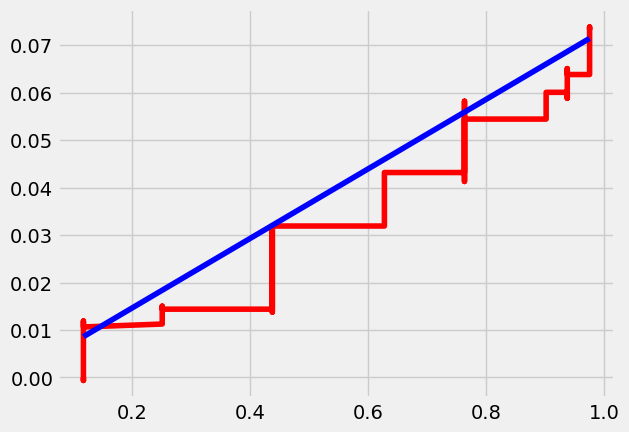

-20.24277

In [6]:
from causalml.inference.tree import UpliftTreeClassifier

# создадим базовое uplift-дерево
uplift_model = UpliftTreeClassifier(
    max_depth=5,
    min_samples_leaf=200,
    min_samples_treatment=50,
    n_reg=100,
    evaluationFunction="ED",
    control_name="0",
)

uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_col].apply(str).values,
                 y=df_train[target_col].values)
                
# предскажите uplift-эффект
uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

qini_df(df_test)
# посчитаем метрики 